In [25]:
import numpy as np

W = np.arange(21).reshape(7, 3)
print(W)
print()
print(W[2])
print(W[5])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]

[6 7 8]
[15 16 17]


In [26]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [27]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [28]:
import sys
sys.path.append('..')
import collections
from common.np import *
from common.layers import Embedding, SigmoidWithLoss

In [29]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [30]:
import numpy as np

# 0에서 9까지의 숫자 중 하나를 랜덤하게 샘플링
np.random.choice(10)

0

In [31]:
np.random.choice(10)

9

In [32]:
words = ['you', 'say', 'goodbye', 'i', 'hello', '.']
np.random.choice(words)

np.str_('you')

In [33]:
np.random.choice(words, size=5, replace=False)

array(['goodbye', 'you', '.', 'hello', 'i'], dtype='<U7')

In [34]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

np.str_('i')

In [35]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)

new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [36]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections

# Negative Sampling 클래스 구현
# chap04/negative_sampling_layer.py
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        if not GPU:  # == CPU
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            
            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0  # target이 뽑히지 않게 하기 위함
                p /= p.sum()  # 다시 정규화 해줌
                negative_sample[i, :] = np.random.choice(self.vocab_size,
                                                         size=self.sample_size,
                                                         replace=False, p=p)
                
        else:
            negative_sample = np.random.choice(self.vocab_size, 
                                               size=(batch_size, self.sample_size), 
                                               replace=True, p=self.word_p)
            
        return negative_sample

In [37]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[4 3]
 [4 1]
 [2 4]]


In [38]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections

In [39]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size 
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

In [40]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Embedding
from negative_sampling_layer import NegativeSamplingLoss

In [41]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size 
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

In [42]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Embedding
from negative_sampling_layer import NegativeSamplingLoss

In [43]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 레이어 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)  # average
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [44]:
import sys
sys.path.append('..')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu
from dataset import ptb

In [45]:
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 1

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)


In [46]:
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 41.59
| 에폭 1 |  반복 501 / 9295 | 시간 101[s] | 손실 33.15
| 에폭 1 |  반복 1001 / 9295 | 시간 202[s] | 손실 27.42
| 에폭 1 |  반복 1501 / 9295 | 시간 304[s] | 손실 26.16
| 에폭 1 |  반복 2001 / 9295 | 시간 408[s] | 손실 25.59
| 에폭 1 |  반복 2501 / 9295 | 시간 513[s] | 손실 25.29
| 에폭 1 |  반복 3001 / 9295 | 시간 615[s] | 손실 25.08
| 에폭 1 |  반복 3501 / 9295 | 시간 715[s] | 손실 24.88
| 에폭 1 |  반복 4001 / 9295 | 시간 814[s] | 손실 24.76
| 에폭 1 |  반복 4501 / 9295 | 시간 915[s] | 손실 24.65
| 에폭 1 |  반복 5001 / 9295 | 시간 1017[s] | 손실 24.56
| 에폭 1 |  반복 5501 / 9295 | 시간 1119[s] | 손실 24.49
| 에폭 1 |  반복 6001 / 9295 | 시간 1220[s] | 손실 24.41
| 에폭 1 |  반복 6501 / 9295 | 시간 1322[s] | 손실 24.37
| 에폭 1 |  반복 7001 / 9295 | 시간 1423[s] | 손실 24.31
| 에폭 1 |  반복 7501 / 9295 | 시간 1526[s] | 손실 24.26
| 에폭 1 |  반복 8001 / 9295 | 시간 1627[s] | 손실 24.23
| 에폭 1 |  반복 8501 / 9295 | 시간 1728[s] | 손실 24.20
| 에폭 1 |  반복 9001 / 9295 | 시간 1831[s] | 손실 24.17


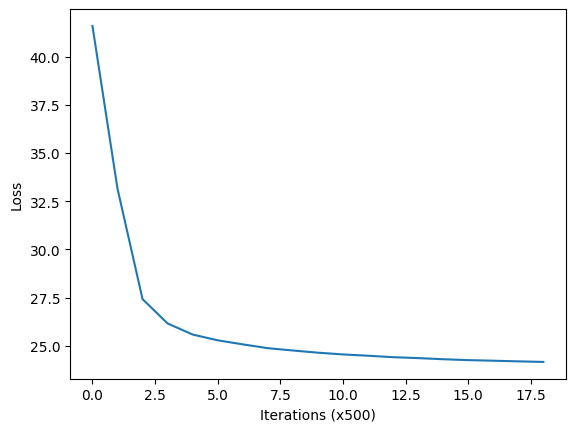

In [47]:
trainer.fit(contexts, target, max_epoch, batch_size, eval_interval=500)
trainer.plot()

In [48]:
import sys
sys.path.append('..')
import pickle
from common.util import most_similar, analogy

In [50]:
pkl_file = './cbow_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)

In [51]:
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']

In [52]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


In [53]:
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slower: 4.734375
 greater: 4.671875
